Epoch [100/5000], Loss: 2.1266e-01
Epoch [200/5000], Loss: 2.1187e-01
Epoch [300/5000], Loss: 1.6616e-02
Epoch [400/5000], Loss: 8.3437e-05
Epoch [500/5000], Loss: 1.9836e-05
Epoch [600/5000], Loss: 1.9832e-05
Epoch [700/5000], Loss: 1.7803e-05
Epoch [800/5000], Loss: 1.7345e-05
Epoch [900/5000], Loss: 1.7738e-05
Epoch [1000/5000], Loss: 1.5658e-05
Epoch [1100/5000], Loss: 1.5650e-05
Epoch [1200/5000], Loss: 1.3505e-05
Epoch [1300/5000], Loss: 1.7874e-05
Epoch [1400/5000], Loss: 2.5668e-05
Epoch [1500/5000], Loss: 9.7134e-06
Epoch [1600/5000], Loss: 1.5696e-05
Epoch [1700/5000], Loss: 3.3800e-05
Epoch [1800/5000], Loss: 8.1975e-06
Epoch [1900/5000], Loss: 1.3176e-05
Epoch [2000/5000], Loss: 6.6269e-06
Epoch [2100/5000], Loss: 3.8561e-05
Epoch [2200/5000], Loss: 1.8767e-05
Epoch [2300/5000], Loss: 5.1490e-06
Epoch [2400/5000], Loss: 5.2469e-06
Epoch [2500/5000], Loss: 2.6548e-05
Epoch [2600/5000], Loss: 9.6158e-06
Epoch [2700/5000], Loss: 4.2406e-06
Epoch [2800/5000], Loss: 3.7890e-06
E

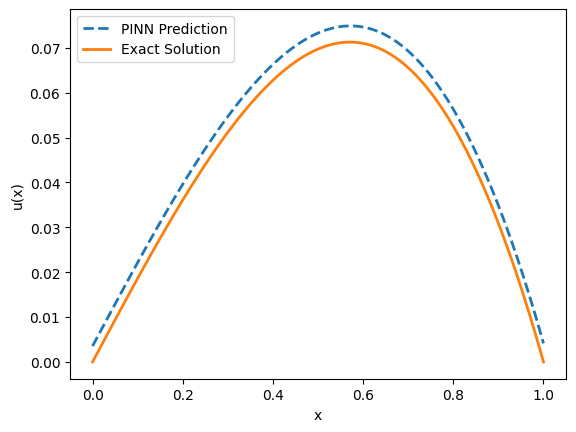

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time

# Set default dtype
torch.set_default_dtype(torch.float32)

# Set random seed
torch.manual_seed(1234)

# random number generator
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name(0))

class PINN(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_layer, n_nodes):
        super(PINN, self).__init__()
        self.n_layer = n_layer

        self.Input = nn.Linear(n_inputs, n_nodes)
        nn.init.xavier_uniform_(self.Input.weight)
        nn.init.constant_(self.Input.bias, 0.0)

        self.Output = nn.Linear(n_nodes, n_outputs)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.constant_(self.Output.bias, 0.0)

        self.Hidden = nn.ModuleList()
        for i in range(self.n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)

    def forward(self, x):
        y = torch.sigmoid(self.Input(x))
        for layer in self.Hidden:
            y = torch.sigmoid(layer(y))
        y = self.Output(y)
        return y


# Define the differential equation
def pde_loss(Net, x, BC_x, BC_u):
    # Gradients
    x.requires_grad_(True)
    u = Net(x)
    ux = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    uxx = torch.autograd.grad(ux, x, torch.ones_like(ux), create_graph=True)[0]

    pde = uxx + u + x

    # Loss functions
    BC_loss = torch.mean((Net(BC_x) - BC_u)**2)
    loss = torch.mean((pde)**2)

    return BC_loss + loss

# Define the collocation points
def gen(n_collocation):
    x = torch.rand((n_collocation, 1))
    return x

# Training
time_start = time.time()
def train(Net, optimizer, num_epochs, n_collocation):
    BC_x = torch.tensor([[0.], [1.]], requires_grad=True)
    BC_u = torch.tensor([[0.], [0.]], requires_grad=True)

    for epoch in range(n_epochs):
        collocation_x = gen(n_collocation)

        optimizer.zero_grad()
        loss = pde_loss(Net, collocation_x, BC_x, BC_u)
        loss.backward()
        optimizer.step()

    #    if epoch % 100 == 0:
     #       print(f'Epoch [{epoch}/{n_epochs}], Loss: {loss.item()}')
        if (epoch+1) % 100 == 0:
          print('Epoch [{}/{}], Loss: {:.4e}'.format(epoch+1, num_epochs, loss.item()))

    print('time:{}'.format(time.time()-time_start))

# Testing
def test(Net, n_points=100):
    x_test = torch.linspace(0, 1, n_points).view(-1, 1)
    u_pred = Net(x_test)
    u_exact = -x_test + torch.sin(x_test) / torch.sin(torch.tensor(1.))

    plt.plot(x_test.detach().numpy(), u_pred.detach().numpy(), label='PINN Prediction', linestyle='--', linewidth=2)
    plt.plot(x_test.detach().numpy(), u_exact.detach().numpy(), label='Exact Solution', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    plt.show()

# PINN setup
n_inputs = 1
n_outputs = 1
n_layers = 5
n_nodes = 50
learning_rate = 0.001
n_collocation = 1000
num_epochs = 5000

# Main
if __name__ == "__main__":
    Net = PINN(n_inputs, n_outputs, n_layers, n_nodes)
    optimizer = optim.Adam(Net.parameters(), lr=learning_rate)

    train(Net, optimizer, num_epochs, n_collocation)
    test(Net)
